## Setup

In [7]:
import sys
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

In [8]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

keras = tf.keras

# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [9]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
  
  
def window_dataset(series, window_size, batch_size=128, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
# Read in data
df = pd.read_csv('./GBPUSD.csv')

# Convert series into datetime type
df.index = pd.to_datetime(df['Date'])

# Save target series
series = df['Close']

#Size of exchange rates
total_size = df.shape[0]
print(total_size)

#Use 80% of data as training, 10% each for validation and to Test 
valid_split_index = int(total_size * 0.8)
test_split_index = int(total_size * 0.1)
x_train = df.iloc[0:valid_split_index].Close
x_valid = df.iloc[valid_split_index:-test_split_index].Close
x_test = df.iloc[-test_split_index:total_size].Close

4852


In [11]:
# Reshape the datsets
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

# Create a Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# normalize training data
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# normalize validation data
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# normalize test data
normalized_x_test = x_train_scaler.transform(x_test_values)

# Normalized to training data
forex_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

## RNN Forecasting

In [ ]:
# Clear any back end stored data due to multiple iterations
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size
window_size = 20

# 2D batches of batch size and features 
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)

# Model architecture
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                      input_shape=[None]), # increases dimensionality f features
  keras.layers.SimpleRNN(100, return_sequences=True), # takes a sequence of batch size, time, dimensionality per time step
  keras.layers.SimpleRNN(100), # produces a single vector as its output
  keras.layers.Dense(1), # gives final predicted value 
])

# create standard learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

# establish optimizer
optimizer = keras.optimizers.Nadam(lr=1e-7)

# Put model all together
model.compile(loss="mean_squared_error",
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

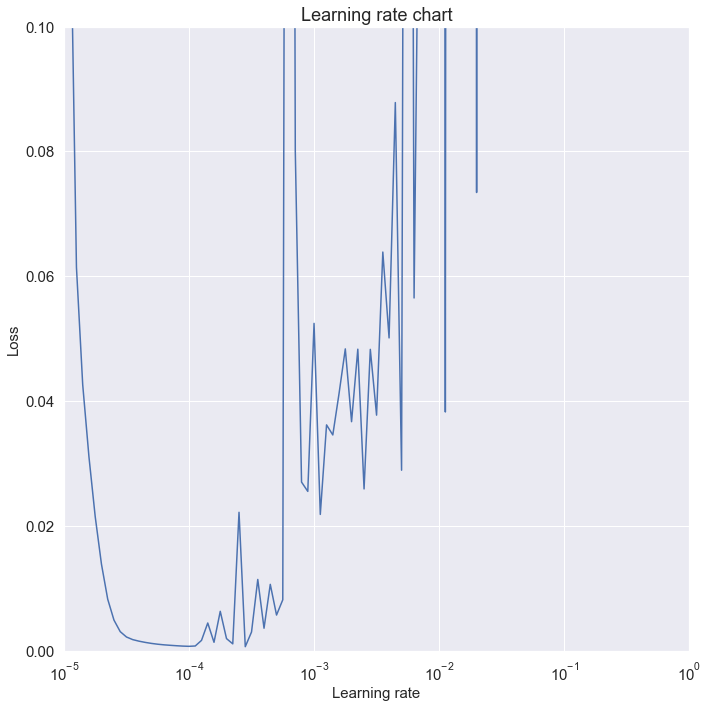

In [14]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title('Learning rate chart', fontsize=18)
plt.xlabel('Learning rate', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([1e-5, 1, 0, .1])
plt.tight_layout()
plt.show()

In [12]:
# create a list of configs to try
def model_configs():
    config = {}
    # define scope of configs
    n_epochs = [100, 500]
    optimizers = [keras.optimizers.Adam(learning_rate=1e-4), keras.optimizers.Nadam(learning_rate=1e-4), keras.optimizers.SGD(learning_rate=1e-4), keras.optimizers.Adagrad(learning_rate=1e-4)]
    losses = [keras.losses.MeanSquaredError(), keras.losses.MeanAbsoluteError()]
    # Make a dictionary of the grid search parameters
    configs = list()
    for epoch in n_epochs:
        for optim in optimizers:
            for loss in losses:
                param_grids = dict(optimizers = optim, loss = loss, epochs=epoch)    # create configs
                configs.append(param_grids)
    print('Total configs: %d' % len(configs))
    return configs

In [ ]:
configs = model_configs()
len(configs)

In [ ]:
from tqdm.notebook import tqdm, trange

# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
# set window size and create input batch sequence
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=128)

x=11

# grid search to find optimal model configuration
for config in tqdm(configs[10:]):
    # create model
    model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    ])

    # set optimizer
    optimizer = config["optimizers"]

    # compile model
    model.compile(loss=config["loss"],
                  optimizer=optimizer,
                  metrics=["mae"])

    #set up save best only checkpoint
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint_rnn_"+str(x), save_best_only=True, verbose=0)

    x = x+1

    early_stopping = keras.callbacks.EarlyStopping(patience=50)

    # fit model
    model.fit(train_set, epochs=config["epochs"],
              validation_data=valid_set,
              callbacks=[early_stopping, model_checkpoint], verbose=0)

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets


Exception ignored in: <function ScopedTFImportGraphDefOptions.__del__ at 0x000002B040E4E0D0>
Traceback (most recent call last):
  File "C:\Users\Ananya\anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 69, in __del__
    c_api.TF_DeleteImportGraphDefOptions(self.options)
AttributeError: options


INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11\assets
INFO:tensorflow:Assets written to: my_checkpoint_rnn_11

In [ ]:
# calculate and store MAE score for all model configurations
mae_df = pd.DataFrame(columns=["MAE score", "config"])
   
for a in range(1, 17):
    config = configs[a-1]
    optim = config["optimizers"].__class__.__name__
    loss = config["loss"].__class__.__name__
    
    config_list = (config["epochs"], optim, loss)
    
    model = keras.models.load_model("my_checkpoint_rnn_"+str(a))
    dense_forecast = model_forecast(model, forex_normalized_to_traindata.flatten()[-test_split_index - window_size:-1], window_size)[:, 0]
    # Undo the scaling
    dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
    mae_score = keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()
    
    mae_df.loc[len(mae_df.index)] = [mae_score, config_list]

mae_df = mae_df.sort_values(by = "MAE score")
print(mae_df)

In [ ]:
mae_df.to_csv("RNN simulations")

## use chosen configuration to get final RNN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = window_dataset(normalized_x_train, window_size, batch_size=128)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.Nadam(lr=2e-4)

model.compile(loss="mean_absolute_error",
              optimizer=optimizer,
              metrics=["mae"])

# Set early stopping to prevent over fitting
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# save best model to load later
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# compile model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint], verbose = 0)

In [17]:
# load the best version of RNN model
model = keras.models.load_model("my_checkpoint")

In [18]:
# get forecasts for test data
rnn_forecast = model_forecast(model, forex_normalized_to_traindata[-test_split_index - window_size:-1], window_size)[:, 0]

In [19]:
rnn_forecast.shape

(485,)

In [21]:
# inverse the scaling/normalization applied to get the result
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(485,)

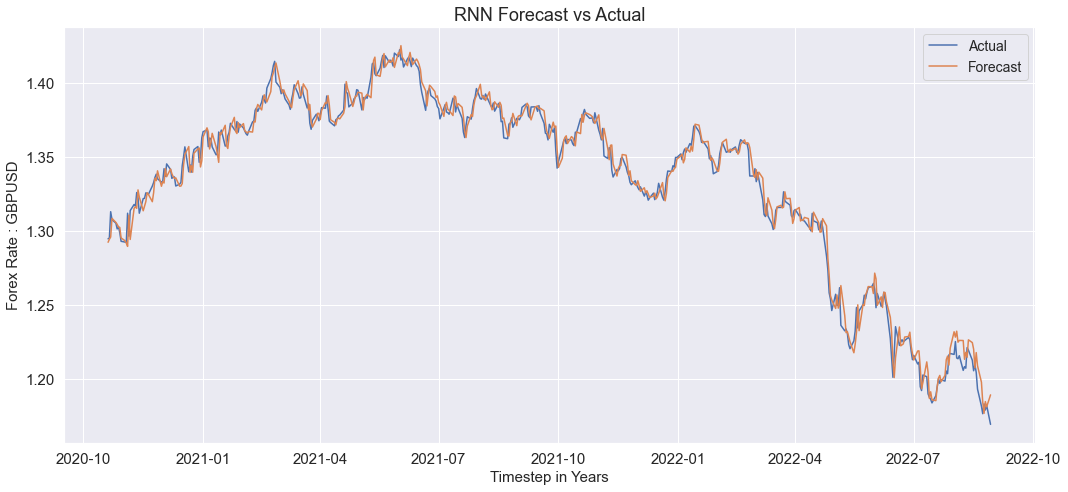

In [22]:
# plot results
plt.figure(figsize=(15, 7))
plt.title('RNN Forecast vs Actual', fontsize=18)
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Forex Rate : GBPUSD', fontsize=15)
plt.xlabel('Timestep in Years', fontsize=15)
plt.tight_layout()
plt.show()

In [26]:
model_scores = pd.read_csv("./Model scores.csv", index_col=0)

# MAE 
rnn_mae = keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

# MAPE in percentage
rnn_mape = mean_absolute_percentage_error(x_test, rnn_unscaled_forecast) * 100

# add both scores against the model's name in the dataframe
model_scores.loc[len(model_scores.index)] = ["RNN", rnn_mae, rnn_mape]

# view the dataframe of scores
model_scores

,Model,MAE,MAPE in %
0,Naive Model,0.004958,0.374773
1,MA5,0.011715,0.890453
2,MA20,0.024235,1.840606
3,"ARIMA (0,1,0)",0.004958,0.374773
4,"Linear model (MA5, MA20)",0.005484,0.414356
5,Dense Neural Network,0.011224,0.858841
6,LSTM,0.002854,0.211474
7,RNN,0.005412,0.410384


In [46]:
model_scores.to_csv("./Model scores.csv")